# Project 3 - Web APIs & Classification

## Data Collection 

I have run the reddit API on seperated notebooks
please refer to Notebook : 
- Project 3 - legal advice Web APIs, 
- Project 3 - relationship_advice Web APIs

## Problem Statement
**Will a legal advice be misclassified as relationship advice?**


## Executive Summary

When people have relationship problems, apart from telling their friends and family, it is not surprised that they tend to share or post the issues on forum like reddit to ask for others'opinion. 
Some relationship issue can be in harm. For example, sex crime, stalking, rape, harresment, divorce or even life thretening scenario etc. 
These issues are indeed involved legal actions or legal consultancy. 

Reddit is a globally well known social news platform,home to thousands of communities.
It can be crucial as if the post owner is able to get appropriate advice or catch the attention in time via reddit, the user engaement will increase. 
When user engagement is enhance, it also facilitates to positive brand image.

Given 2 subreddit :r/legaladvice and r/relationshipadvice. We are helping Reddit to categorize the text messages(inclduing posts titles and selftext) into the above two predefined categories, by using two classification models to predict whether a posts be misclassified as relationship issue but actually it will be more appropriate to be labelled as a legal issue.

#### Here is the answers: 
The two models has high accuracy score, 97%-98% of the posts are classified correctly, both Naive Bayes and Logistic Regression models are able to classify the subreddits.
- The top related words for relationship advice are : feel,love,girl,gf,think,date           
- The top related words for legal advice are :
sign,illegal,car,report,police,charge

However,there are 12 cases asking for legal advice but are labelled as relationship advice. These misclassified posts are mostly related to human relationship. For example, posts have mentioned the following words:, ex, husband,family, father, month, stepfather, parents, Sexting etc, they are all misclassified as relationship advice even though there are wordings in the posts,decribing the sceniro like crimial, raped, kill, beaten, abuse.
 
#### Improvement:
We are assuming the model will be able to spot posts that invloved wordings like 'divorce', 'sexual abuse' posts as they are in the boundary between legal and relationship. Unfortunatedly, no such posts are found. 

As we are only examine around 1000 posts at this time, we should collect at least 10000 posts to do analysis. We can also run on others classifcaiton models such as random forrest and K-
Nearest Neighbour. 

#### Recommedation:
Knowing that there is limitation of the classification models,we can educate Reddit admins and the reddit moderators to be more aware and pay attention to cases invloving family and parenting problems. 


### Contents:

- [Import CSV files](#Import-CSV-files)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Preprocessing & Modeling](#Preprocessing-&-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
    - [Finding misclassified posts](#Finding-mislassified-post)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)


In [1]:
#import libraries

import regex as re
import pandas as pd
import numpy as np
import string

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams



# Import CSV files 

In [5]:
df_legal = pd.read_csv('../legaladvice1.csv')
df_relation = pd.read_csv('../relationshipadvice.csv')

# Data Cleaning & EDA

In [6]:
#check the shape of raw df before drop duplicate
df_legal.shape

(11413, 102)

In [7]:
#check the shape of raw df before drop duplicate
df_relation.shape

(12219, 102)

In [8]:
#set to view all of the columns
pd.set_option('display.max_columns', None)

In [9]:
#drop duplicate rows by 'name'
df_legal.drop_duplicates(subset='name', inplace=True)


In [10]:
#drop duplicate rows by 'name'
df_relation.drop_duplicates(subset='name', inplace=True)


In [11]:
#shape after dropping duplicate
df_legal.shape

(1060, 102)

In [12]:
#shape after dropping duplicate
df_relation.shape

(1296, 102)

In [13]:
# Reset index.
df_legal.reset_index(drop=True, inplace=True)
df_relation.reset_index(drop=True, inplace=True)

In [14]:
#check if the index are reset 
df_legal.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id
0,NaN,legaladvice,This is not a megathread. You can still post ...,t2_l5m4n,False,NaN,0,False,COVID-19 FAQ (a work-in-progress),[],r/legaladvice,False,6,NaN,0,False,t3_fgpvcv,False,dark,0.97,NaN,public,4447,5,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,4447,NaN,True,NaN,1588041630.0,star,[],{'gid_3': 1},NaN,True,NaN,1.583922e+09,text,6,NaN,NaN,text,self.legaladvice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,True,Quality Contributor,[],False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,fgpvcv,True,NaN,UsuallySunny,NaN,0,True,all_ads,False,[],False,dark,/r/legaladvice/comments/fgpvcv/covid19_faq_a_w...,all_ads,True,https://www.reddit.com/r/legaladvice/comments/...,1237075,1.583893e+09,3,NaN,False,NaN
1,NaN,legaladvice,[Main FAQ Page](https://www.reddit.com/r/legal...,t2_l5m4n,False,NaN,0,False,Links to all /r/legaladvice pages on COVID-19,[],r/legaladvice,False,6,NaN,0,False,t3_g8lftz,False,dark,0.85,NaN,public,51,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,51,NaN,True,NaN,False,star,[],{},NaN,True,NaN,1.587961e+09,text,6,NaN,NaN,text,self.legaladvice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,True,Quality Contributor,[],False,NaN,NaN,moderator,t5_2rawz,NaN,NaN,NaN,g8lftz,True,NaN,UsuallySunny,NaN,1,True,all_ads,False,[],False,dark,/r/legaladvice/comments/g8lftz/links_to_all_rl...,all_ads,True,https://www.reddit.com/r/legaladvice/comments/...,1237075,1.587932e+09,0,NaN,False,NaN
2,NaN,legaladvice,[NJ]The reason I ask this…when I don’t answer ...,t2_6f97dtpf,False,NaN,0,False,I’m 18 years old and wish to move away from my...,[],r/legaladvice,False,6,NaN,0,False,t3_gg7cuv,False,dark,0.96,NaN,public,5137,0,{},NaN,False,[],NaN,False,False,NaN,{},Other Civil Matters,False,5137,NaN,False,NaN,1588992965.0,NaN,[],{},NaN,True,NaN,1.589021e+09,text,6,NaN,NaN,text,self.legaladvice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,True,NaN,[],False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,gg7cuv,True,NaN,throwawaycam20,NaN,112,True,all_ads,False,[],False,NaN,/r/legaladvice/comments/gg7cuv/im_18_years_old...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237075,1.588993e+09,0,NaN,False,6860856c-aae2-11e3-b863-12313d191273
3,NaN,legaladvice,I am the oldest of three children who are bene...,t2_mbf3x,False,NaN,0,False,"I am a beneficiary of an irrevocable trust, wh...",[],r/legaladvice,False,6,NaN,0,False,t3_ggem1r,

In [15]:
#check if the index are reset 
df_legal.tail()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id
1055,NaN,legaladvice,"Hey there,\n\nI have a friend who's immunocomp...",t2_tr7ck,False,NaN,0,False,"PA, USA. Friend is immunocompromised, what if ...",[],r/legaladvice,False,6,NaN,0,True,t3_ggl2dz,False,dark,1.0,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589079e+09,text,6,NaN,NaN,text,self.legaladvice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,ggl2dz,True,NaN,Hiddenagenduh,NaN,0,True,all_ads,False,[],False,NaN,/r/legaladvice/comments/ggl2dz/pa_usa_friend_i...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237115,1.589050e+09,0,NaN,False,NaN
1056,NaN,legaladvice,My father signed the lease 10+ years ago and p...,t2_5raix,False,NaN,0,False,Family has finally had it with my mentally uns...,[],r/legaladvice,False,6,NaN,0,True,t3_ggl0f8,False,dark,1.0,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589079e+09,text,6,NaN,NaN,text,self.legaladvice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,ggl0f8,True,NaN,ivzie,NaN,1,True,all_ads,False,[],False,NaN,/r/legaladvice/comments/ggl0f8/family_has_fina...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237115,1.589050e+09,0,NaN,False,NaN
1057,NaN,legaladvice,"I got this message from Reddit, what dose this...",t2_5ez52ijj,False,NaN,0,False,What dose this mean?,[],r/legaladvice,False,6,NaN,0,True,t3_ggl05v,False,dark,1.0,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},Non-US,False,1,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589078e+09,text,6,NaN,NaN,text,self.legaladvice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rawz,NaN,NaN,NaN,ggl05v,True,NaN,MrMemelord420,NaN,1,True,all_ads,False,[],False,NaN,/r/legaladvice/comments/ggl05v/what_dose_this_...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237115,1.589050e+09,0,NaN,False,055ea1d8-e00f-11e5-8d1f-0e9a5cc19cc7
1058,NaN,legaladvice,I know I need to file federal taxes and I alre...,t2_65t1s,False,NaN,0,False,I have lived out of the country for 4 years no...,[],r/legaladvice,False,6,NaN,0,True,t3_ggkyr2,False,dark,1.0,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589078e+09,text,6,

In [16]:
#check if the index are reset 
df_relation.head()


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id
0,NaN,relationship_advice,**TL;DR on Throwaways:** If you wish to reques...,t2_4det0,False,NaN,0,False,"[meta] It's not required, but if you make a ne...",[],r/relationship_advice,False,6,NaN,0,False,t3_d3okss,False,dark,0.96,NaN,public,2353,2,{},95023d06-57d9-11e8-af87-0e4322199064,False,[],NaN,False,False,NaN,{},NaN,False,2353,NaN,False,NaN,1568378263.0,NaN,[],{'gid_1': 1},NaN,True,NaN,1.568407e+09,text,6,NaN,NaN,text,self.relationship_advice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,True,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,True,Press Inquiries,[],False,NaN,NaN,moderator,t5_2r0cn,NaN,NaN,NaN,d3okss,True,NaN,eganist,NaN,0,True,all_ads,False,[],False,dark,/r/relationship_advice/comments/d3okss/meta_it...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,3025899,1.568378e+09,6,NaN,False,NaN
1,NaN,relationship_advice,We get the stress from social isolation is bad...,t2_4det0,False,NaN,0,False,[meta] One (1) day bans for moral judgment pos...,[],r/relationship_advice,False,6,NaN,0,False,t3_g7ukh7,False,dark,0.86,NaN,public,360,0,{},95023d06-57d9-11e8-af87-0e4322199064,False,[],NaN,False,False,NaN,{},NaN,False,360,NaN,False,NaN,1587826036.0,NaN,[],{},NaN,True,NaN,1.587854e+09,text,6,NaN,NaN,text,self.relationship_advice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,True,Press Inquiries,[],False,NaN,NaN,NaN,t5_2r0cn,NaN,NaN,NaN,g7ukh7,True,NaN,eganist,NaN,0,True,all_ads,False,[],False,dark,/r/relationship_advice/comments/g7ukh7/meta_on...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,3025899,1.587826e+09,0,NaN,False,NaN
2,NaN,relationship_advice,My partner is giving me the silent treatment a...,t2_2ue0m0vf,False,NaN,0,False,My 35f partner livid at me 33m for not wanting...,[],r/relationship_advice,False,6,NaN,0,False,t3_ggdgjc,False,dark,0.96,NaN,public,374,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,374,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589050e+09,text,6,NaN,NaN,text,self.relationship_advice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r0cn,NaN,NaN,NaN,ggdgjc,True,NaN,BigTacoBowl,NaN,120,True,all_ads,False,[],False,NaN,/r/relationship_advice/comments/ggdgjc/my_35f_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3025899,1.589022e+09,0,NaN,False,NaN
3,NaN,relationship_advice,This is honestly so stupid. I've been thinking...,t2_6fajkdzg,False,NaN,0,Fal

In [17]:
#check if the index are reset 
df_relation.tail()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id
1291,NaN,relationship_advice,For months I had been asking him to not bring ...,t2_t96hu,False,NaN,0,False,My(28f) Bf(31) constant phone use was damaging...,[],r/relationship_advice,False,6,NaN,0,True,t3_ggizc4,False,dark,1.0,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589072e+09,text,6,NaN,NaN,text,self.relationship_advice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r0cn,NaN,NaN,NaN,ggizc4,True,NaN,niceteefbeef,NaN,0,True,all_ads,False,[],False,NaN,/r/relationship_advice/comments/ggizc4/my28f_b...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026094,1.589043e+09,0,NaN,False,NaN
1292,NaN,relationship_advice,It’s been a reoccurring thought; but would you...,t2_683cz5of,False,NaN,0,False,Would a short break/holiday like this appeal t...,[],r/relationship_advice,False,6,NaN,0,True,t3_ggiyfz,False,dark,0.5,NaN,public,0,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,0,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589072e+09,text,6,NaN,NaN,text,self.relationship_advice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r0cn,NaN,NaN,NaN,ggiyfz,True,NaN,Mr-Swhich,NaN,4,True,all_ads,False,[],False,NaN,/r/relationship_advice/comments/ggiyfz/would_a...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026094,1.589043e+09,0,NaN,False,NaN
1293,NaN,relationship_advice,I need to know what to do with this person I l...,t2_54o4r7lp,False,NaN,0,False,Me (21M) don't know what to do about this 'fri...,[],r/relationship_advice,False,6,NaN,0,True,t3_ggiy8l,False,dark,1.0,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,1,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.589072e+09,text,6,NaN,NaN,text,self.relationship_advice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r0cn,NaN,NaN,NaN,ggiy8l,True,NaN,blowiepart13,NaN,3,True,all_ads,False,[],False,NaN,/r/relationship_advice/comments/ggiy8l/me_21m_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026094,1.589043e+09,0,NaN,False,NaN
1294,NaN,relationship_advice,My bf (M28) and I (M25) have been together a w...,t2_65qnqb8s,False,NaN,0,False,Quarentine straining relationships,[],r/relationship_advice,False,6,NaN,0,True,t3_ggiw5q,False,dark,1.0,NaN,public,1,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,Fal

In [18]:
#only keep 4 columns for both subreddit 
df_legal.drop(df_legal.columns.difference(['name','title','selftext','subreddit']),axis =1, inplace =True)
df_relation.drop(df_relation.columns.difference(['name','title','selftext','subreddit']),axis =1, inplace =True)


In [19]:
#check if the other columns are dropped
df_legal.head()

,subreddit,selftext,title,name
0,legaladvice,This is not a megathread. You can still post ...,COVID-19 FAQ (a work-in-progress),t3_fgpvcv
1,legaladvice,[Main FAQ Page](https://www.reddit.com/r/legal...,Links to all /r/legaladvice pages on COVID-19,t3_g8lftz
2,legaladvice,[NJ]The reason I ask this…when I don’t answer ...,I’m 18 years old and wish to move away from my...,t3_gg7cuv
3,legaladvice,I am the oldest of three children who are bene...,"I am a beneficiary of an irrevocable trust, wh...",t3_ggem1r
4,legaladvice,The company I work for is shutting down it's p...,Company won't let us take home tools we didn't...,t3_gfskgg


In [20]:
#check if the other columns are dropped
df_relation.head()

,subreddit,selftext,title,name
0,relationship_advice,**TL;DR on Throwaways:** If you wish to reques...,"[meta] It's not required, but if you make a ne...",t3_d3okss
1,relationship_advice,We get the stress from social isolation is bad...,[meta] One (1) day bans for moral judgment pos...,t3_g7ukh7
2,relationship_advice,My partner is giving me the silent treatment a...,My 35f partner livid at me 33m for not wanting...,t3_ggdgjc
3,relationship_advice,This is honestly so stupid. I've been thinking...,My (32F) boyfriend (45m) asked me if I love ou...,t3_ggbn4t
4,relationship_advice,"My family and our neighbors are pretty close, ...",My neighbors autistic son (14) is obsessed wit...,t3_gg6dft


In [21]:
#combines selftext ann title in a new columns 
df_legal['message'] = df_legal['title'] + ' ' + df_legal['selftext']
df_relation['message'] = df_relation['title'] + ' ' + df_relation['selftext']


In [22]:
#drop name, title and selftext
df_legal.drop(['title', 'selftext','name'], axis =1, inplace=True)
df_relation.drop(['title', 'selftext','name'], axis =1, inplace=True)


In [23]:
#ensure only 2 columns left
df_legal.head()

,subreddit,message
0,legaladvice,COVID-19 FAQ (a work-in-progress) This is not ...
1,legaladvice,Links to all /r/legaladvice pages on COVID-19 ...
2,legaladvice,I’m 18 years old and wish to move away from my...
3,legaladvice,"I am a beneficiary of an irrevocable trust, wh..."
4,legaladvice,Company won't let us take home tools we didn't...


In [24]:
#ensure only 2 columns left
df_relation.head()

,subreddit,message
0,relationship_advice,"[meta] It's not required, but if you make a ne..."
1,relationship_advice,[meta] One (1) day bans for moral judgment pos...
2,relationship_advice,My 35f partner livid at me 33m for not wanting...
3,relationship_advice,My (32F) boyfriend (45m) asked me if I love ou...
4,relationship_advice,My neighbors autistic son (14) is obsessed wit...


In [25]:
#check missing value
df_legal.isnull().sum()

subreddit     0
message      12
dtype: int64

In [26]:
#check missing value
df_relation.isnull().sum()

subreddit    0
message      0
dtype: int64

In [27]:
#drop the missing value
df_legal.dropna(axis=0,inplace=True)
df_relation.dropna(axis=0,inplace=True)

In [28]:
#ensure missing value are dropped after dropna
df_legal.isnull().sum()

subreddit    0
message      0
dtype: int64

In [29]:
# Reset index.
df_legal.reset_index(drop=True, inplace=True)
df_relation.reset_index(drop=True, inplace=True)

In [30]:
#export to csv before clean data, for the use of verifying misclassified posts later
df_legal[['message']].to_csv('raw_legaladvice1.csv',index = False)
df_relation[['message']].to_csv('raw_relationshipadvice.csv',index = False)

### Pre-Processing 

Data cleaning and pre processing by using Stemming, regular expression and cleaning. 

- Tokenizing
- Regular Expressions
- Lemmatizing/Stemming
- Cleaning (i.e. removing HTML)

In [31]:
#random pick a posts to have a glacne of the message for data cleaning
#to understand what need to be removed
df_legal['message'][996]

'Landlord wants to evict my cousin. My cousin, an Iraq and Afghanistan combat veteran has an emotional support animal, and a letter from his therapist at the VA. His landlord wants to evict him because his dog barks at people when they come into his home. The landlord claimed his dog is "vicious" and he needs to get rid of the dog or he\'ll be evicted. Anybody know the legality of this?'

In [32]:
#to understand what need to be removed
df_relation['message'][996]

"Should I (21F) stop being friends with my best friend (21F) over her inappropriate friendship with my boyfriend (21M)? We are all 21. My boyfriend and I have been dating for 11 months and he has been close friends with my best friend for three years now. He had always had a crush on her, and told me that in school when we were friends. He even asked her out, and she said no. They remained friends and began hanging out together at his house getting drunk.\n\nFast forward to when we began dating. I always knew they were close but I didn't know just how friendly they were with each other. Once every few weeks, they would hang out at his and get drunk, he would essentially ignore my messages for hours on end (which is respectful imo, but when we would hang out he would constantly be replying to other peoples messages) and he would invite me over after when he was really wasted.\n\nI was uncomfortable with their relationship, told them both this, and neither really listened. Turns out, whi

In [33]:
#Instantiate PorterStemmer()
#get stemmer stand by 
porter = PorterStemmer()

In [34]:
#define clean data function with stemming, will use this for the first round data cleaning
def clean_data(text):
    """define function to clear data"""
#for text in df_legal['message']:
    text = str(text)    #make sure every text is string 
    text = re.sub('\w*\d\w*', '', text) #remove words contain digtial 
    text = re.sub('\[.*?\]', '' ,text)  #remove words inside [] and []. e.g [NYC]
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) # Remove hyperlinks
    text = re.sub(r'\&\w*;', '', text)  #remove HTML symbols
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuation
    text = re.sub(r'\s\s+', ' ', text)   #remove '/n' and white space
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) #remove all single character
    text = text.lower().split() #convert to lower case and split into individual words
    #text_tokens = tokenizer.tokenize
    
    stemmed_text = [porter.stem(word) for word in text]
    return( " ".join( stemmed_text ))
    

In [35]:
# define clean data function 2 without stemming, as stemming will cut the words into meaningless words,
# will use this for second round data cleaning if needed
def clean_data2(text):
    """define function to clear data"""
#for text in df_legal['message']:
    text = str(text)    #make sure every text is string 
    text = re.sub(r'\w*\d\w*', '', text) #remove words contain digtial 
    text = re.sub(r'\[.*?\]', '' ,text)  #remove words inside [] and []. e.g [NYC]
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) # Remove hyperlinks
    text = re.sub(r'\&\w*;', '', text)  #remove HTML symbols
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) #make a list of punctuation remove at once
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) #remove all single character
    text = re.sub(r'\s\s+', ' ', text)   #remove '/n' and white space
    text = text.lower().split() #convert to lower case and split into individual words
    
    return( " ".join(text))

In [36]:
#apply clean_data function to df_legal['message']
df_legal['message'] = df_legal['message'].apply(clean_data)
df_relation['message'] = df_relation['message'].apply(clean_data)

In [37]:
#check if the clean_data function is in effect
df_legal['message'][996]

'landlord want to evict my cousin my cousin an iraq and afghanistan combat veteran ha an emot support anim and letter from hi therapist at the va hi landlord want to evict him becaus hi dog bark at peopl when they come into hi home the landlord claim hi dog is viciou and he need to get rid of the dog or hell be evict anybodi know the legal of thi'

In [38]:
#check if the clean_data function is in effect
df_relation['message'][996]

'should stop be friend with my best friend over her inappropri friendship with my boyfriend we are all my boyfriend and have been date for month and he ha been close friend with my best friend for three year now he had alway had crush on her and told me that in school when we were friend he even ask her out and she said no they remain friend and began hang out togeth at hi hous get drunk fast forward to when we began date alway knew they were close but didnt know just how friendli they were with each other onc everi few week they would hang out at hi and get drunk he would essenti ignor my messag for hour on end which is respect imo but when we would hang out he would constantli be repli to other peopl messag and he would invit me over after when he wa realli wast wa uncomfort with their relationship told them both thi and neither realli listen turn out whilst theyr togeth the talk constantli turn sexual ie what your kiss techniqu he show her on hi hand what am like in bed sexual likes

### EDA 
- common words used on both subreddit
- top words of both subreddit
- add more words to stop words if neccssary 

In [39]:
#concating the df_legal and df_relation
combine_df = pd.concat([df_legal,df_relation],ignore_index=True)
combine_df

,subreddit,message
0,legaladvice,covid faq workinprogress thi is not megathread...
1,legaladvice,link to all rlegaladvic page on covid ffcra ca...
2,legaladvice,i’m year old and wish to move away from my par...
3,legaladvice,i am beneficiari of an irrevoc trust who in ye...
4,legaladvice,compani wont let us take home tool we didnt ch...
...,...,...
2339,relationship_advice,my bf constant phone use wa damag my mental he...
2340,relationship_advice,would short breakholiday like thi appeal to yo...
2341,relationship_advice,me dont know what to do about thi friendship w...
2342,relationship_advice,quarentin strain relationship my bf and have b...


In [40]:
#mapping legal advice is 1 , relationship advice is 0 
#combine_df['legal'] = [1 if combine_df.loc[i,'subreddit'] == 'legaladvice' else 0 for i in range(combine_df.shape[0])]
combine_df['target'] = combine_df['subreddit'].map({'legaladvice': 1, 'relationship_advice': 0})

In [41]:
#seprating legal and relationship into 2 vector from combine_df
vector_legal = combine_df[combine_df['target'] == 1]['message']
vector_relation = combine_df[combine_df['target'] == 0]['message']

In [42]:
# Instantiate CountVectorizer.
cvec = CountVectorizer(stop_words ='english')
#cvec_fit = cvec.fit_transform(combined_list)

# Fit our CountVectorizer on the legal_advice features.
legal_combined_vec = pd.DataFrame(cvec.fit_transform(vector_legal).toarray(),
                           columns= cvec.get_feature_names())


In [43]:
# Fit our CountVectorizer on the relationshop advice feature.
relation_combined_vec = pd.DataFrame(cvec.fit_transform(vector_relation ).toarray(),
                           columns= cvec.get_feature_names())

### Top words and plot bar chart 


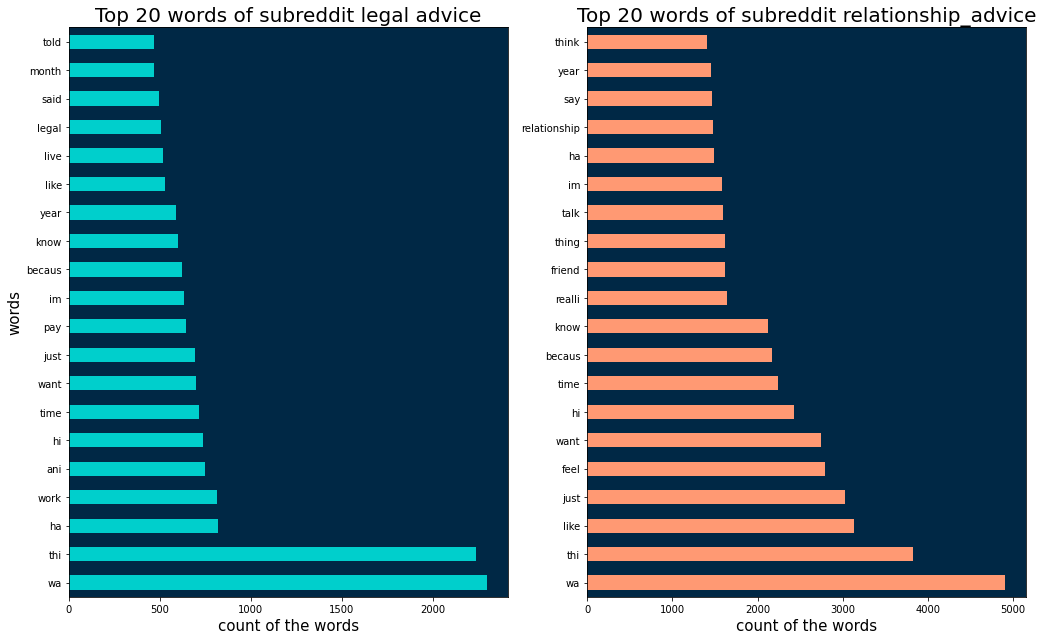

In [44]:
#plot the top words of both legal and relationship.
#we can see that there are some common words e.g just, like, im 

fig = plt.figure(2, figsize=(15,9))
ax1 = fig.add_subplot(1, 2, 1)
legal_top = legal_combined_vec.sum(axis=0)
legal_top.sort_values(ascending=False).head(20).plot(kind='barh',color = '#00cfcc')
plt.title('Top 20 words of subreddit legal advice',fontsize=20)
plt.ylabel('words',fontsize= 15)
plt.xlabel('count of the words',fontsize= 15)
ax1.set_facecolor('#002845')


ax2 = fig.add_subplot(1, 2, 2)
relation_top = relation_combined_vec.sum(axis=0)
relation_top.sort_values(ascending=False).head(20).plot(kind='barh', color= '#ff9973')
plt.title('Top 20 words of subreddit relationship_advice',fontsize=20)
plt.xlabel('count of the words',fontsize= 15)
ax2.set_facecolor('#002845')

plt.tight_layout()
plt.show()

In [45]:
#we will have closer look of these top words, will add them to new stop words list 
#Since the words are appearing on both subreddit, it didn't add value to the modeling 
#I will dig deeper of the common words 
#apply the data clean function again to the 'message' columns and creating lists for count vectorizer and EDA
clean_legal = [clean_data(df_legal['message'][i]) for i in range (len(df_legal['message']))]
clean_relation = [clean_data(df_relation['message'][i]) for i in range (len(df_relation['message']))]

combined_list = [str(clean_relation) , str(clean_legal)]


In [46]:
# now CountVectorizer on the this combined_list of clean_legal and clean_relation
clean_combined_vec = pd.DataFrame(cvec.fit_transform(combined_list).toarray(),
                           columns= cvec.get_feature_names(),index =('relationship', 'legal'))

In [47]:
#have a look into the vector dataframe
clean_combined_vec.head()

,aa,aaa,aaaaaaaand,aaaall,aaannd,aang,ab,aback,abandon,abbot,abbott,abbrevi,abc,abd,abdomen,abid,abil,abit,abl,ableist,abnorm,abort,abortionunw,abouts,aboutstil,abov,aboveaverag,abra,abroad,abrupt,abruptli,abscess,absenc,absent,absolut,absolv,absorb,absurd,absurdli,abt,abu,abundantli,abusive,abusiveaggress,abusivemanipul,abysm,ac,academ,academi,academia,acc,accel,accent,accents,accept,acceptableunaccept,access,accessori,accid,accident,accidentali,accidentr,accommod,accomod,accompani,accompl,accomplish,accord,accordingli,account,accountsor,accountsphon,accountssign,accredit,accrosd,accru,accrual,acct,accu,accumul,accur,accusatori,ace,ach,achiev,acid,acknowledg,acpa,acquaint,acquir,acquisit,acr,acrobat,acronym,act,actdefinit,action,activ,activatingu,activedo,activeonlin,actor,actress,actual,acu,ad,ada,adafmla,adam,adamantli,adapt,add,addenda,addendum,adder,addict,addit,addremov,address,adequ,adhd,adher,adjac,adjoin,adjud,adjust,adjustor,admin,administ,administr,adminstr,admir,admiss,admit,admittedli,adolesc,adopt,ador,adress,adtech,adult,adulthood,adulting,adultmi,advac,advanc,advantag,adventur,adver,advert,adverti,advi,advic,adviceam,advicefocu,adviceinsight,adviceopinionsrec,advicethought,advisewi,advisor,advoc,advocaci,aerospac,af,afaik,affair,affect,affectexplain,affectionate,affectionit,affectionn,affectivemateri,affidavit,affili,affirm,afford,affraid,afghanistan,afloat,afoot,afor,afraid,africa,african,aftermarket,aftermath,afternoon,afterthought,afterward,afterword,ag,againbut,againnot,againsoon,againt,againth,againtold,age,agegap,agegend,agenc,agenda,agent,agenth,ageout,aggr,aggrav,aggress,aggressor,aggriev,agian,agit,agnost,ago,agoh,agoish,agoraphob,agosh,agothi,agr,agreed,agreedbc,agreement,agress,aground,ah,ahe,ahead,ahem,ahmaud,ahol,ahold,aid,aids,aim,aimlessli,aint,air,airbnb,airlin,airpod,airport,aisl,aita,aka,akin,akward,akword,al,alabama,alabi,alameda,alarm,alarmedmi,alaska,albani,albeit,alberta,album,alclov,alcohol,alcoholicaddict,alcoholwhich,alcol,aldo,alert,alevel,alex,alford,alia,alic,alice,alien,align,alik,alimoni,alittl,aliv,alleg,allegationsmi,allegedli,allerg,allergi,allevi,alli,allot,allow,allowed,alltoofamiliar,allud,alon,alonei,aloneor,aloneshar,aloneunsur,alongsid,aloof,alot,alpha,alreadi,alreadymeag,alright,alrighti,alsocan,alt,altar,alter,alterc,altern,altima,altogeth,alway,alzheim,amanda,amass,amateur,amaz,amazingbeautifulawesom,amazingli,amazon,ambassador,ambigu,ambit,ambiti,ambiv,ambul,amd,amen,amend,america,american,ami,amic,amid,amidst,amirit,amiss,ammend,ammo,ammunit,amountar,amounti,amp,ampamp,ampl,amplifi,amu,ana,anaheim,anal,analget,anali,analog,analprost,analysi,analysiswhich,analyst,analyt,analyz,anatomi,anchorag,ancientcityfloatingmarketvjpg,andan,andbhabout,andhav,andor,android,andyeah,anecdot,anem,anew,angel,anger,angiosarcoma,angl,angri,angrier,angrili,ani,anim,animo,ankl,anna,anniversari,annonym,announc,annoy,annual,anonym,anonymitywhen,anorex,anorexia,anoth,answer,answers,answersadv,ant,antagon,anthem,anti,antibiot,antibodi,antic,anticip,anticoncept,antidepress,antimasturb,antimen,antiporn,antisoci,antithesi,antivaxetc,anton,antonio,antonioselma,anxieti,anxiou,anybodi,anybody,anymor,anymore,anyon,anyt,anytb,anyth,anythin,anythingi,anytim,anyways,anywh,anywhoo,ap,apapr,apart,apartment,apartmenttow,apathet,apathi,apex,apocalyp,apolig,apolog,apologet,app,appal,appar,appart,appea,appeal,appear,apperantli,apperci,appetit,appgroup,appint,appl,applaud,appli,applianc,applic,applicabilityconflict,apply,applyget,appo,appoint,appoit,appov,apprai,apprecci,appreci,apprecita,apprehen,approach,approch,appropri,approv,approvalwait,approveddeni,approx,approxim,appsserv,appt,apreci,apric,april,apron,apt,arbery,arbitr,arbitrari,arbitrarili,arborist,arc,arcad,architect,architectur,archived,archiveorg,area,areand,aren,arent,arew,argelian,argu,arguabl,arguement,arguing,argument,argumentsfight,ari,arizona,arkansa,arm,armelbow,armi,armoir,arom,aroommateincalifornia,arou,aroundth,arraign,arrang,arrest,arres

In [48]:
#dropping the non words 
drop_cols = ['aa','aaa','aaaaaaaand','aaaall','aaannd','aang','ab','aback']
clean_combined_vec = clean_combined_vec.drop(drop_cols, axis=1)

In [49]:
#Transpost the dataframe
c_data_t = clean_combined_vec.T


In [50]:
c_data_t.head(10)

,relationship,legal
abandon,23,27
abbot,0,1
abbott,0,1
abbrevi,3,1
abc,0,8
abd,1,0
abdomen,0,1
abid,2,4
abil,9,17
abit,2,0


In [51]:
#find the top words by using dictionary
sort_dict ={}
for c in c_data_t.columns:
    top = c_data_t[c].sort_values(ascending=False).head(30)
    sort_dict[c] = list(zip(top.index, top.values))

sort_dict

{'relationship': [('wa', 4908),
  ('thi', 3823),
  ('like', 3134),
  ('just', 3031),
  ('feel', 2795),
  ('want', 2747),
  ('hi', 2430),
  ('time', 2238),
  ('becau', 2169),
  ('know', 2120),
  ('realli', 1639),
  ('friend', 1617),
  ('thing', 1616),
  ('talk', 1595),
  ('im', 1583),
  ('ha', 1493),
  ('relationship', 1480),
  ('say', 1466),
  ('year', 1451),
  ('think', 1407),
  ('said', 1258),
  ('dont', 1252),
  ('tri', 1246),
  ('make', 1235),
  ('love', 1186),
  ('told', 1181),
  ('don', 1059),
  ('ask', 1042),
  ('start', 1005),
  ('day', 988)],
 'legal': [('wa', 2295),
  ('thi', 2234),
  ('ha', 821),
  ('work', 816),
  ('ani', 746),
  ('hi', 738),
  ('time', 715),
  ('want', 698),
  ('just', 695),
  ('pay', 644),
  ('im', 634),
  ('becau', 619),
  ('know', 599),
  ('year', 588),
  ('like', 528),
  ('live', 518),
  ('legal', 507),
  ('said', 496),
  ('month', 470),
  ('told', 468),
  ('ask', 464),
  ('day', 460),
  ('hou', 443),
  ('need', 436),
  ('say', 434),
  ('state', 428),


In [52]:
#check common words in legal and relationship
#we can see that there are some common words appears in both subreddit 
for columns, topwords in sort_dict.items():
    print(columns)
    print(' ,'.join(sorted([word for word, count in topwords[0:30]])))
    print('---')

relationship
ask ,becau ,day ,don ,dont ,feel ,friend ,ha ,hi ,im ,just ,know ,like ,love ,make ,realli ,relationship ,said ,say ,start ,talk ,thi ,thing ,think ,time ,told ,tri ,wa ,want ,year
---
legal
ani ,ask ,becau ,car ,compani ,day ,dont ,ha ,hi ,hou ,im ,just ,know ,legal ,like ,live ,month ,need ,pay ,said ,say ,state ,thi ,time ,told ,tri ,wa ,want ,work ,year
---


In [53]:
#make a list of these 30 top words 
from collections import Counter
words =[]
for subreddit in c_data_t:
    top =[word for (word, count) in sort_dict[subreddit]]
    for t in top:
        words.append(t)


In [54]:
words

['wa',
 'thi',
 'like',
 'just',
 'feel',
 'want',
 'hi',
 'time',
 'becau',
 'know',
 'realli',
 'friend',
 'thing',
 'talk',
 'im',
 'ha',
 'relationship',
 'say',
 'year',
 'think',
 'said',
 'dont',
 'tri',
 'make',
 'love',
 'told',
 'don',
 'ask',
 'start',
 'day',
 'wa',
 'thi',
 'ha',
 'work',
 'ani',
 'hi',
 'time',
 'want',
 'just',
 'pay',
 'im',
 'becau',
 'know',
 'year',
 'like',
 'live',
 'legal',
 'said',
 'month',
 'told',
 'ask',
 'day',
 'hou',
 'need',
 'say',
 'state',
 'compani',
 'car',
 'tri',
 'dont']

In [55]:
#use Counter to find the common words appear in both subreddit
#will add these words into new stop words : just , im, like, know, told, going, got, did, years , dont,said, want,months, time
Counter(words).most_common()

[('wa', 2),
 ('thi', 2),
 ('like', 2),
 ('just', 2),
 ('want', 2),
 ('hi', 2),
 ('time', 2),
 ('becau', 2),
 ('know', 2),
 ('im', 2),
 ('ha', 2),
 ('say', 2),
 ('year', 2),
 ('said', 2),
 ('dont', 2),
 ('tri', 2),
 ('told', 2),
 ('ask', 2),
 ('day', 2),
 ('feel', 1),
 ('realli', 1),
 ('friend', 1),
 ('thing', 1),
 ('talk', 1),
 ('relationship', 1),
 ('think', 1),
 ('make', 1),
 ('love', 1),
 ('don', 1),
 ('start', 1),
 ('work', 1),
 ('ani', 1),
 ('pay', 1),
 ('live', 1),
 ('legal', 1),
 ('month', 1),
 ('hou', 1),
 ('need', 1),
 ('state', 1),
 ('compani', 1),
 ('car', 1)]

# New stop words list

In [56]:
#add new stop word list 
#also adding 'relationship' and 'legal' into the stop words like as these 2 words are too easy to identify, providing insufficient insights 

new_stopwords = [word for word, count in Counter(words).most_common() if count ==2] 
new_stopwords.append('relationship')
new_stopwords.append('legal')

#first stop words list
new_stopwords



['wa',
 'thi',
 'like',
 'just',
 'want',
 'hi',
 'time',
 'becau',
 'know',
 'im',
 'ha',
 'say',
 'year',
 'said',
 'dont',
 'tri',
 'told',
 'ask',
 'day',
 'relationship',
 'legal']

In [57]:
#add the new_stopwords list into the stop_words
stop_words = text.ENGLISH_STOP_WORDS.union(new_stopwords)

cvec = CountVectorizer(stop_words = stop_words)
#cvec_fit = cvec.fit_transform(combined_list)

# Fit our CountVectorizer on the features
sw_combined_vec = pd.DataFrame(cvec.fit_transform(combine_df['message']).toarray(),
                           columns= cvec.get_feature_names())

In [58]:
sw_combined_vec.shape

(2344, 11046)

In [59]:
#creating new count vector with new stop words and plot the bar chart 
legal_sw_combined = pd.DataFrame(cvec.fit_transform(vector_legal ).toarray(),
                           columns= cvec.get_feature_names())
relation_sw_combined = pd.DataFrame(cvec.fit_transform(vector_relation ).toarray(),
                           columns= cvec.get_feature_names())

### Top words with new stop words and plot bar chart 


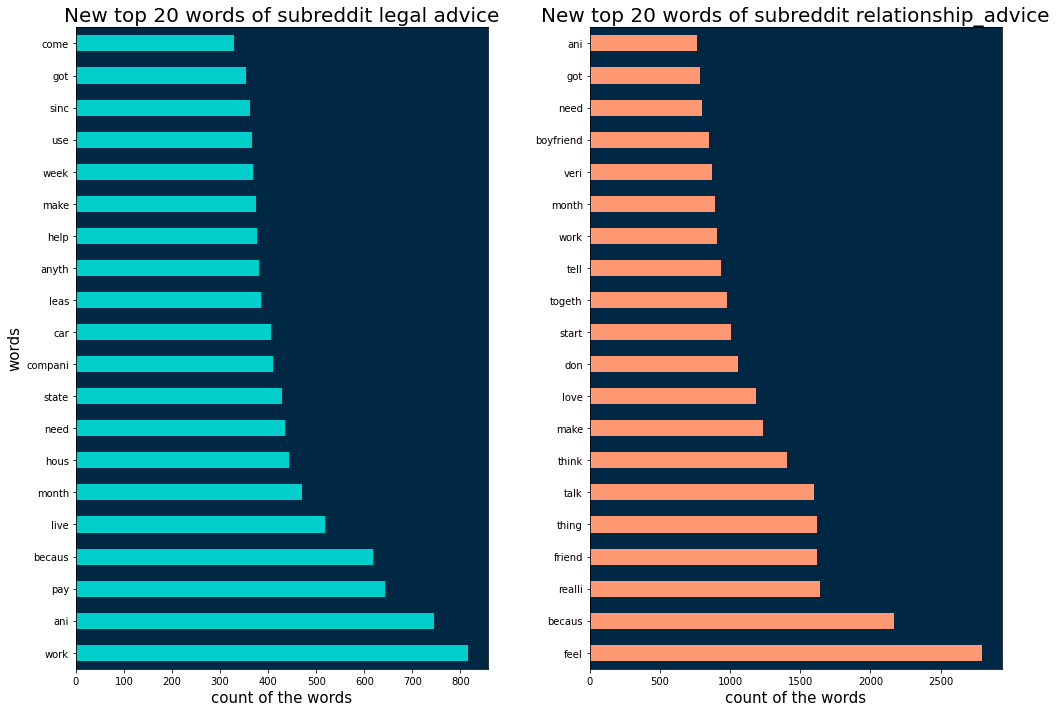

In [60]:
#plot the top words of both legal and relationship.
#we can see that there are some common words e.g just, like, im 

fig = plt.figure(2, figsize=(15,10))
ax1 = fig.add_subplot(1, 2, 1)
legal_swtop = legal_sw_combined.sum(axis=0)
legal_swtop.sort_values(ascending=False).head(20).plot(kind='barh',color ='#00cfcc')
plt.title('New top 20 words of subreddit legal advice',fontsize=20)
plt.ylabel('words',fontsize= 15)
plt.xlabel('count of the words',fontsize= 15)
ax1.set_facecolor('#002845')


ax2 = fig.add_subplot(1, 2, 2)
relation_swtop = relation_sw_combined.sum(axis=0)
relation_swtop.sort_values(ascending=False).head(20).plot(kind='barh', color ='#ff9973')
plt.title('New top 20 words of subreddit relationship_advice',fontsize=20)
plt.xlabel('count of the words',fontsize= 15)
ax2.set_facecolor('#002845')

plt.tight_layout()
plt.show()


## Preprocessing & Modeling

### CountVectorizer

In [61]:
#The easiest way for us to convert text data into a structured, numeric X dataframe
#fitting a default CountVectorizer
X= combine_df[['message']]
y= combine_df['target']



In [62]:
#check the shape of combine_df before train test split
combine_df.shape

(2344, 3)

In [63]:
# stratify y as the classes are a bit imbalanced

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [64]:
#cheap the shape after spliting 
X_train.shape

(1758, 1)

In [65]:
X_test.shape

(586, 1)

In [66]:
# Instantiate CountVectorizer with my new stop words list
cvec = CountVectorizer(stop_words = stop_words)

# Fit our CountVectorizer on the training data and transform training data.
X_train_vec = pd.DataFrame(cvec.fit_transform(X_train['message']).todense(),
                           columns= cvec.get_feature_names())


In [67]:
X_test_vec = pd.DataFrame(cvec.transform(X_test['message']).todense(),
                         columns =cvec.get_feature_names())

In [68]:
X_train_vec.shape

(1758, 9711)

In [69]:
X_test_vec.shape

(586, 9711)

### Baseline accuracy

We need to calculate baseline accuracy in order to tell if our model is better than null model (predicting the plurality class).

In [70]:
#baseline accouary is 55%, need the model work better than the baseline   #prrdict the marjority of class
#y_test.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.552901
1    0.447099
Name: target, dtype: float64

### Naive Bayes

In [71]:
# Instantiate our model!
nb = MultinomialNB()

In [72]:
# Fit our model!
model = nb.fit(X_train_vec, y_train)

In [73]:
# Generate our predictions!
predictions = model.predict(X_test_vec)

In [74]:
# Score our model on the training set.
model.score(X_train_vec, y_train)

0.984641638225256

In [75]:
# Score our model on the testing set.
model.score(X_test_vec, y_test)

0.9726962457337884

In [76]:
#evaluaion score
cross_val_score(nb, X_train_vec, y_train, cv=5).mean()

0.9681478243978244

### Confusion matrix of naive bayes

In [77]:
# Generate a confusion matrix.
confusion_matrix(y_test, predictions)

array([[320,   4],
       [ 12, 250]])

In [78]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [79]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 320
False Positives: 4
False Negatives: 12
True Positives: 250


In [80]:
# confusion matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')

Accuracy: 0.973
Sensitivity: 0.954
Specificity: 0.988
Precision: 0.984



Interpretation : 

- The naive base model correctly predicts 97.3% of observations.
- The misclassifion rate is 100%-97.3% = 2.7%
- Among posts that naive base model predicted to be in legal advice, 95.4% of them are correctly classified.
- Among posts that are in relationship advice, our model has 98.8% of them correctly classified.
- Among posts that are in legal advice, the model has 98.4% of them correctly classified.

Go to [Finding misclassified post of naive bayes](#Finding-misclassified-post-of-naive-bayes) to check out the misclassified posts

#### Top 50 feature of Naive Bayes

In [81]:
#refence from https://datascience.stackexchange.com/questions/65219/find-the-top-n-features-from-feature-set-using-absolute-values-of-feature-log-p
#nb.feature_log_prob gives us each class the estimated log probability of the features
#.argsort() give indexes of features sorted with their log-probabilities

# For positive class
sorted_prob_class_1_ind = nb.feature_log_prob_[1, :].argsort()
# For negative class
sorted_prob_class_0_ind = nb.feature_log_prob_[0, :].argsort()

In [82]:
#create a list of the feature names so that we can related the index to the features
features_lst = list(cvec.get_feature_names())

In [83]:
#sorted_prob_class_1_ind.

Most_imp_words_1 = []
Most_imp_words_0 = []

#find the top 50 features in legal advice (class 1)
for index in sorted_prob_class_1_ind[-50:-1]: 
    Most_imp_words_1.append(features_lst[index])

#find the top 50 features in relationship advice (class 2)
for index in sorted_prob_class_0_ind[-50:-1]:
    Most_imp_words_0.append(features_lst[index])

print("Top 50 features for legal advice:\n")
print(Most_imp_words_1)

print("\n" + "-"*100)

print("\nTop 50 features for relationship advice:\n")
print(Most_imp_words_0)

Top 50 features for legal advice:

['thank', 'landlord', 'ago', 'properti', 'veri', 'file', 'claim', 'mom', 'paid', 'person', 'order', 'check', 'insur', 'question', 'apart', 'receiv', 'rent', 'employ', 'job', 'right', 'sign', 'start', 'come', 'home', 'befor', 'money', 'leas', 'friend', 'did', 'onli', 'new', 'got', 'thing', 'anyth', 'sinc', 'make', 'help', 'car', 'week', 'use', 'compani', 'state', 'need', 'hous', 'month', 'live', 'becaus', 'pay', 'ani']

----------------------------------------------------------------------------------------------------

Top 50 features for relationship advice:

['everyth', 'text', 'happen', 'thought', 'famili', 'long', 'ive', 'peopl', 'onli', 'girl', 'good', 'week', 'anyth', 'befor', 'person', 'guy', 'end', 'life', 'didnt', 'sex', 'come', 'someth', 'way', 'live', 'did', 'lot', 'date', 'sinc', 'help', 'alway', 'ani', 'boyfriend', 'got', 'need', 'veri', 'month', 'tell', 'work', 'togeth', 'start', 'don', 'love', 'make', 'think', 'talk', 'friend', 'thing',

In [84]:
Most_imp_words_1_str = str(Most_imp_words_1)

In [85]:
Most_imp_words_0_str = str(Most_imp_words_0 )

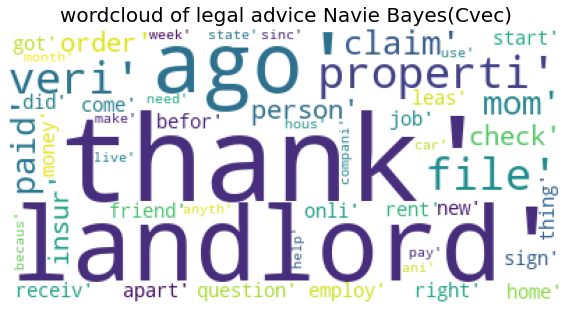

In [86]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=50).generate(Most_imp_words_1_str)

rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.title ('wordcloud of legal advice Navie Bayes(Cvec)', fontsize =20)
plt.show()

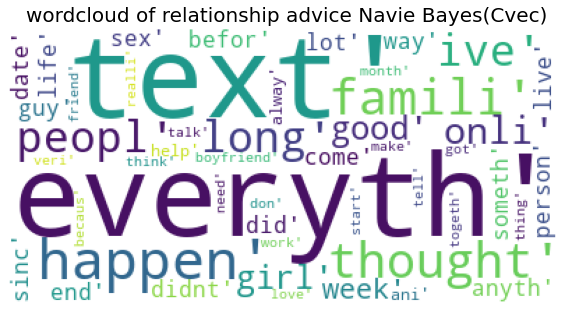

In [87]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=50).generate(Most_imp_words_0_str)

rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.title ('wordcloud of relationship advice Navie Bayes(Cvec)', fontsize =20)
plt.show()

### Result of top 50 features of Naive Bayes 

Firstly, words are stemmed so they were cut. But it is still understandable so I will prefer to keep the words stemmed.

Secondly, I am not satisfied with the result of relationship advice as there are still some words like 'didn't','did', 'thought', 'ive' are not good indicators in providing sufficiant insight. 

I understand that words like 'help' , 'need' will be common words as both subreddit are asking for advice. 

This is the limitation of analyzing the text by single words. Hence I will try n-gram and may add more stop words in [New stop words list](#New-stop-words-list) if needed.




### Looking for new top 50 features using Tfidf and n-gram

In [88]:
new_stopwords = text.ENGLISH_STOP_WORDS.union(new_stopwords)

In [89]:
#Instantiate CountVectorizer 
#using n-gram and max features 
#try to get more interptable top features
new_tfidf = TfidfVectorizer(stop_words = new_stopwords , ngram_range=(1,2),max_features=5000)


In [90]:
#making X_train and X_test into dataframe with tfidf
X_train_tvec = pd.DataFrame(new_tfidf.fit_transform(X_train['message']).todense(),
                           columns= new_tfidf.get_feature_names())

X_test_tvec = pd.DataFrame(new_tfidf.transform(X_test['message']).todense(),
                         columns =new_tfidf.get_feature_names())

In [91]:
nb_tvec= MultinomialNB()

In [92]:
#fit the model
model = nb_tvec.fit(X_train_tvec, y_train)

In [93]:
#predition of X_test
predictions_tvec = model.predict(X_test_tvec)

In [94]:
#training score
model.score(X_train_tvec, y_train)

0.9783845278725825

In [95]:
#testing score
model.score(X_test_tvec, y_test)

0.9709897610921502

### Top 50 features of naive bayes with Tfidf and N-gram

In [96]:
# For positive class
tvec_sorted_prob_class_1_ind = nb_tvec.feature_log_prob_[1, :].argsort()
# For negative class
tvec_sorted_prob_class_0_ind = nb_tvec.feature_log_prob_[0, :].argsort()

In [97]:
#create a list of the feature names so that we can related the index to the features
tvec_features_lst = list(new_tfidf.get_feature_names())

In [98]:
tvec_Most_imp_words_1 = []
tvec_Most_imp_words_0 = []

#find the top 50 features in legal advice (class 1)
for index in tvec_sorted_prob_class_1_ind[-50:-1]: 
    tvec_Most_imp_words_1.append(tvec_features_lst[index])

#find the top 50 features in relationship advice (class 2)
for index in tvec_sorted_prob_class_0_ind[-50:-1]:
    tvec_Most_imp_words_0.append(tvec_features_lst[index])
    

print("Top 50 features for legal advice:\n")
print(tvec_Most_imp_words_1)

print("\n" + "-"*100)

print("\nTop 50 features for relationship advice:\n")
print(tvec_Most_imp_words_0)

Top 50 features for legal advice:

['account', 'make', 'polic', 'onli', 'sinc', 'right', 'mom', 'got', 'thank', 'court', 'friend', 'home', 'lawyer', 'claim', 'unemploy', 'email', 'order', 'law', 'question', 'anyth', 'help', 'job', 'new', 'paid', 'properti', 'week', 'insur', 'apart', 'charg', 'month', 'check', 'file', 'becaus', 'need', 'landlord', 'rent', 'receiv', 'money', 'use', 'employ', 'hous', 'sign', 'state', 'live', 'leas', 'car', 'ani', 'compani', 'pay']

----------------------------------------------------------------------------------------------------

Top 50 features for relationship advice:

['didn', 'break', 'anyth', 'thought', 'famili', 'didnt', 'live', 'week', 'ive', 'long', 'come', 'did', 'end', 'life', 'someth', 'sinc', 'person', 'peopl', 'good', 'ex', 'ani', 'way', 'got', 'need', 'lot', 'text', 'help', 'girlfriend', 'alway', 'work', 'guy', 'date', 'veri', 'girl', 'sex', 'month', 'tell', 'start', 'boyfriend', 'togeth', 'make', 'think', 'don', 'thing', 'love', 'talk', '

In [99]:
tvec_Most_imp_words_1_str = str(tvec_Most_imp_words_1)

In [100]:
tvec_Most_imp_words_0_str = str(tvec_Most_imp_words_0)

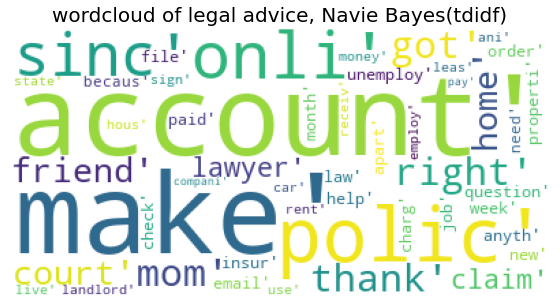

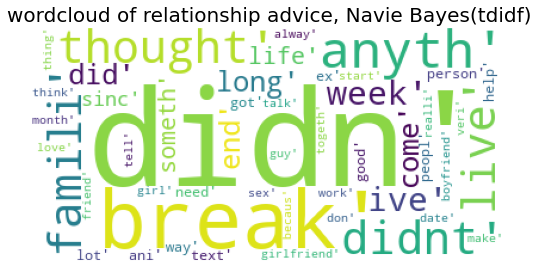

In [101]:
wordcloud_leg_nb = WordCloud(stopwords=stop_words, background_color="white", max_words=50).generate(tvec_Most_imp_words_1_str)
wordcloud_res_nb = WordCloud(stopwords=stop_words, background_color="white", max_words=50).generate(tvec_Most_imp_words_0_str)

rcParams['figure.figsize'] = 8, 20
plt.imshow(wordcloud_leg_nb)
plt.axis("off")
plt.title ('wordcloud of legal advice, Navie Bayes(tdidf)', fontsize =20)
plt.tight_layout()
plt.show()


rcParams['figure.figsize'] = 8, 20
plt.imshow(wordcloud_res_nb)
plt.axis("off")
plt.title ('wordcloud of relationship advice, Navie Bayes(tdidf)', fontsize =20)
plt.tight_layout()
plt.show()



### Result of score of top 50 features of Naive Bayes with Tfidf and N gram

Firstly, the training and tesing score achieve 0.97 which is satisfying. 

However, it is surprising that the top features are worse than naive bayes with count vector. There are still some words like 'didn','did', 'thought', 'ive' which are not good indicators in providing sufficiant insight. 

In legal advice word cloud, the features are also proivding less insight. For example, 'make','sinc (belived that means since), got

**I tried to add these words in stop words but then the model they become overfitting with test score 0.90 while training score is 0.97.**

Maybe there is some limitation on Naive Bayes ,I will move on to logistic regression model and compare the result.


### Create and compare to logistic regression with count vectorizer


In [102]:
#Instantiate model.
logreg = LogisticRegression()   #regression is predicting probability and also the classs which it belongs to 

# Step 2: Fit our model
logreg.fit(X_train_vec, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Intercept: [-0.03282732]
Logistic Regression Coefficient: [[ 2.21434400e-02  2.62301764e-05 -1.39040487e-07 ...  3.31394289e-02
   1.16049015e-01  1.79150047e-02]]


In [103]:
# Generate predicted values.
#after predict ,here is the first 5 output i get 
#first is 1 mean it is legal , the other 3 are predicted as relationship

#this is the prediction of the class
print(f'Logistic Regression predicted values: {logreg.predict(X_train_vec.head())}')



Logistic Regression predicted values: [1 0 0 0 1]


In [104]:
#Generate predicted probabilities.
#here we use X train for demonstration, so it has not using the model on the test yet 
print(f'Logistic Regression predicted probabilities: \n{logreg.predict_proba(X_train_vec.head())}')    

Logistic Regression predicted probabilities: 
[[7.96655125e-03 9.92033449e-01]
 [9.99999456e-01 5.43525776e-07]
 [9.37383811e-01 6.26161892e-02]
 [1.00000000e+00 1.91621506e-10]
 [9.90242807e-03 9.90097572e-01]]


In [105]:
#as we interest in postivie , which is 2nd columns 
logreg.predict_proba(X_test_vec)[:5]


array([[9.99995883e-01, 4.11685362e-06],
       [9.98995501e-01, 1.00449943e-03],
       [9.99692790e-01, 3.07210453e-04],
       [8.50049544e-01, 1.49950456e-01],
       [1.35831442e-02, 9.86416856e-01]])

In [106]:
#Test Accuracy Score
#around 95.59% predcit correctly
print(f'Logistic Regression Accuracy Score: {logreg.score(X_test_vec, y_test)}')

Logistic Regression Accuracy Score: 0.9726962457337884


In [107]:
# Generate predictions.
log_preds = logreg.predict(X_test_vec)

In [108]:
#train score is 99%, overfitting
logreg.score(X_train_vec, y_train)  

0.9994311717861206

In [109]:
logreg.predict(X_train_vec.head(10))

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [110]:
# Evaluate how well our model generalizes
cross_val_score(logreg, X_train_vec, y_train, cv=5).mean()

0.9567777130277131

### Confusion matrix of logistic regression 

In [111]:
log_tn, log_fp, log_fn, log_tp = confusion_matrix(y_test,log_preds).ravel()

In [112]:
print("True Negatives: %s" % log_tn)
print("False Positives: %s" % log_fp)
print("False Negatives: %s" % log_fn)
print("True Positives: %s" % log_tp)

True Negatives: 314
False Positives: 10
False Negatives: 6
True Positives: 256


In [113]:
# confusion matrix metrics

accuracy = (log_tp+log_tn)/(log_tp+log_fp+log_fn+log_tn)
sensitivity = log_tp/(log_tp+log_fn)
specificity = log_tn/(log_tn+log_fp)
precision = log_tp/(log_tp+log_fp)

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')

Accuracy: 0.973
Sensitivity: 0.977
Specificity: 0.969
Precision: 0.962



Interpretation : 

- The naive base model correctly predicts 97.3% of observations.
- The misclassifion rate is 100%-97.3% = 2.7%
- Among posts that naive base model predicted to be in legal advice, 97.7% of them are correctly classified.
- Among posts that are in relationship advice, our model has 96.9% of them correctly classified.
- Among posts that are in legal advice, the model has 96.2% of them correctly classified.

### Performance measurement- Relationship between Sensitivity and Specificity

The ROC curve is generated by varying our threshold from 0 to 1. it is for visualizing the tradeoff between sensitivity and specificity and understand how well-separated our populations are.

Using area under the ROC curve (abbreviated ROC AUC or AUC ROC) to quantify the gap between our distributions.

In [114]:
#create Dateframe of y_test and the pred_proba
log_pred_proba = [i[1] for i in logreg.predict_proba(X_test_vec)]   #i[1] here is the positive which is 2nd columns 

log_pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':log_pred_proba})

log_pred_df.head()   #seeing the true value and observe proba

,true_values,pred_probs
2244,0,0.000004
1824,0,0.001004
1556,0,0.000307
1706,0,0.149950
518,1,0.986417


In [115]:
#get the roc_auc_score
roc_auc= roc_auc_score(log_pred_df['true_values'], log_pred_df['pred_probs'])

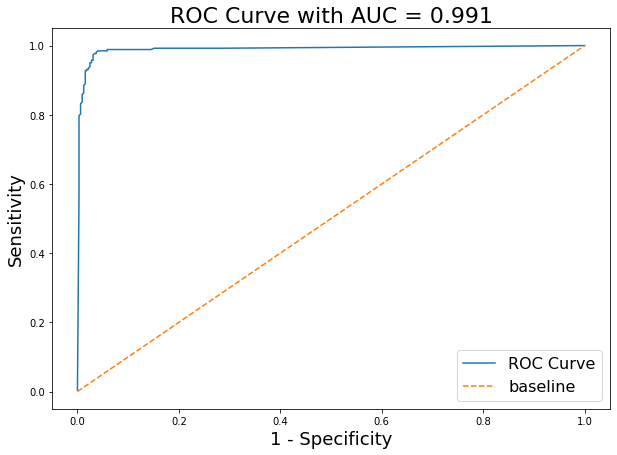

In [116]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. 
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(log_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(log_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(log_pred_df["true_values"], log_pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18) # 1-specicify is false positive 

# Create legend.
plt.legend(fontsize=16);




My interpretion of ROC AUC :
roc_auc_score is 0,991 , near to 1 ((1 is the maximum score), the positive and negative populations are perfectly separated and my model is as good as it can get.

### Top 50 features of Logistic regression

In [117]:
## Function researched and borrowed from Stackoverflow
#https://stackoverflow.com/questions/43576614/logistic-regression-how-to-find-top-three-feature-that-have-highest-weights
def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


In [118]:
show_most_informative_features(cvec, logreg)


	-1.2655	feel           		0.8995	sign           
	-1.0582	love           		0.8885	illeg          
	-0.7999	girl           		0.8090	car            
	-0.7704	gf             		0.7772	report         
	-0.7055	think          		0.7488	polic          
	-0.6150	date           		0.7371	charg          
	-0.6096	realli         		0.6922	employ         
	-0.5626	talk           		0.6862	law            
	-0.5558	girlfriend     		0.6593	use            
	-0.5554	togeth         		0.6548	sell           
	-0.5521	safest         		0.6467	properti       
	-0.5483	guy            		0.6353	pay            
	-0.5279	everyon        		0.6178	court          
	-0.5218	don            		0.6165	locat          
	-0.5128	bf             		0.6113	california     
	-0.4884	quarantin      		0.6063	order          
	-0.4862	long           		0.6001	lawyer         
	-0.4728	becom          		0.5993	landlord       
	-0.4619	weird          		0.5967	state          
	-0.4562	thing          		0.5744	allow          
	-0.4412	tell       

In [119]:
#using this function for plotting wordcloud
def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    
    test = []
    test2 = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        test.append(fn_1)
        test2.append(fn_2)
    return test, test2

In [120]:
test_list = show_most_informative_features(cvec, logreg)

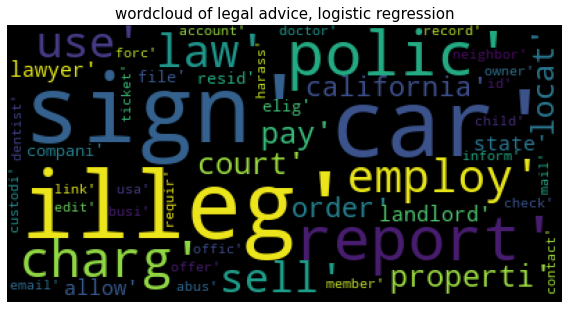

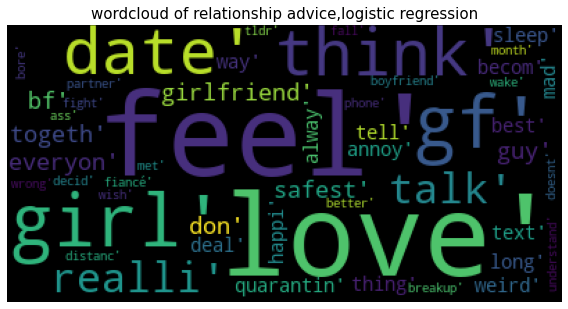

In [121]:
wordcloud_leg_lr = WordCloud(stopwords=stop_words, background_color="black", max_words=50).generate(str(test_list[1]))
wordcloud_res_lr = WordCloud(stopwords=stop_words, background_color="black", max_words=50).generate(str(test_list[0]))


rcParams['figure.figsize'] = 8, 20
plt.imshow(wordcloud_leg_lr)
plt.axis("off")
plt.title ('wordcloud of legal advice, logistic regression', fontsize =15)
plt.tight_layout()
plt.show()

rcParams['figure.figsize'] = 8, 20
plt.imshow(wordcloud_res_lr)
plt.axis("off")
plt.title ('wordcloud of relationship advice,logistic regression', fontsize =15)

plt.tight_layout()
plt.show()

### Result of score and top 50 features of logistic regression with count vectorize

Firstly, the training and tesing score are 0.99 and 0.97. It is a bit overfitting.

The top features from logistic regression are making more sense.
We can see that the words in legal advice are factual basic and related to law and order. For instance, sign (believed that this is signing the documents), illegal (stemmed words), employer and pay(related to employment law), police, landlord appeares in both naive bayes and logistic regression. 

Words in relationship advice are obviously different and straight forward, such as feel, love, talk, date,boyfriend, girlfriend. I can say that these are good indicators in providing insight. 

On the contrary,the two big words love and feel are missing in naive bayes 



## Piplines and Grid Search
As using Tfidf has a perfect score and Logistic regression provide good features, now i will use Tfidf Vectorizer and Logistic regression in gridsearchCV to optimize the score

In [122]:
#Instantiate model.
tfidf = TfidfVectorizer()
#first stop words list : new_stopwords

#second stop words list : new_stopwords_topfea

In [123]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('log_reg' ,LogisticRegression())
])
pipe_params = {
    'tfidf__max_features': [2_000, 3_000, 4_000, 5_000],
    'tfidf__stop_words' :['english',new_stopwords],
    'tfidf__ngram_range': [(1,1), (1,2),(1,3)],           
    'log_reg__solver' :['lbfgs'], 
    'log_reg__multi_class' :['auto'], 
    'log_reg__random_state': [42]               
}

# Grid Search!
gs_cv = GridSearchCV(pipe, param_grid=pipe_params, verbose=1)
gs_cv.fit(X_train['message'], y_train)
score_train = gs_cv.best_score_
score_test = gs_cv.score(X_test['message'], y_test)
params_train = gs_cv.best_params_

print('best score_train' + str(round(score_train,3)))
print('best score_test'+ str(round(score_test,3)))
print('best params'+ str(params_train))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.3min finished


best score_train0.969
best score_test0.974
best params{'log_reg__multi_class': 'auto', 'log_reg__random_state': 42, 'log_reg__solver': 'lbfgs', 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}


## Evaluation and Conceptual Understanding

### Finding misclassified post of naive bayes

Based on the [Confusion matrix of naive bayes](#Confusion-matrix-of-naive-bayes) , there are 12 false negative posts and 4 false postive posts. 

In [124]:
#pd.DataFrame({'actual_v': y_test, 'prediction': predictions, 'text':list(X_test['message'])})
mis_post_df = pd.DataFrame({'actual_v': y_test, 'predict_v': predictions, 'text':list(X_test['message'])})
mis_post_df.head()

,actual_v,predict_v,text
2244,0,0,where did hi sex drive go i’v been date my boy...
1824,0,0,someon hook up with lie about be singl i’m mal...
1556,0,0,i may just be drunk at but am in love with my ...
1706,0,0,do teenag girl still have stuf anim in their r...
518,1,1,want to sell book of other peopl true storiesc...


In [125]:
mis_post1 = mis_post_df[mis_post_df['actual_v']!=mis_post_df['predict_v']]
mis_post1

,actual_v,predict_v,text
15,1,0,sold alcohol to minor locat bc canada just did...
2064,0,1,my mom caught me head person diffus the other ...
428,1,0,i’m move out and my mom’ super crazi so wanna ...
398,1,0,so don’t know how to tag thi but my ex all the...
379,1,0,scare paranoid of sext mistak i’ll keep thi sh...
687,1,0,pleas clarifi someth for me so my famili ha al...
609,1,0,neighbor is drive me up the share wall partial...
1945,0,1,how do convinc my parent to let me pay my own ...
689,1,0,should call the polic on my dad and bro note i...
1198,0,1,corona viru hoax believ one of my close friend...


In [126]:
#loading the original data before data cleaning
#for the use of verifying misclassified posts refer to In[27]
raw_df_legal = pd.read_csv('raw_legaladvice1.csv')
raw_df_relation = pd.read_csv('raw_relationshipadvice.csv')

**legal advice misclassified as relationship advice**
To answer my problem statment , I will mainly examine those legal advice posts that are missclassified. As the top features in Naive base are less significant indictors, I will examine the false negative posts from naive bayes.

I have read through the 12 misclassified posts.  
They are mostly related to human relationship and did mention the following words: ex, husband,family, father, month, stepfather, parents, Sexting

As the posts are lengthy, I didn't print them all out. I cite some 
example sentencse below: 


In [127]:
#this is serious, 'crimial tag', raped', 'kill', 'beaten'are mentioned but still misclassificated 
raw_df_legal.message[1010]
print('Teenager looking for advice on helping a girl...To start off with why there\'s a criminal tag, her stepdad is a real, and excuse my language, but the human shitstain makes me sick whenever I think about what he\'s done. He has, to list: raped her at least twice, beaten her, tried to touch her before, makes her feel like she can\'t breathe ')
print('------------------')
print('Back to the list of offenses by fuckstick of a stepdad: pulled a gun on her when he was drunk, threatened to kill her when she tried to run away, and undoubtedly more that she hasn\'t told me. I\'ve advised family, but they\'re all in different states,')
print('------------------')
print('**I\'m begging you, Reddit, help me find out what she could do to get out of that situation, or if any custody lawyers read this, tell me where she\'ll go.**')

Teenager looking for advice on helping a girl...To start off with why there's a criminal tag, her stepdad is a real, and excuse my language, but the human shitstain makes me sick whenever I think about what he's done. He has, to list: raped her at least twice, beaten her, tried to touch her before, makes her feel like she can't breathe 
------------------
Back to the list of offenses by fuckstick of a stepdad: pulled a gun on her when he was drunk, threatened to kill her when she tried to run away, and undoubtedly more that she hasn't told me. I've advised family, but they're all in different states,
------------------
**I'm begging you, Reddit, help me find out what she could do to get out of that situation, or if any custody lawyers read this, tell me where she'll go.**


In [128]:
#domestic abuse 
raw_df_legal.message[813]
print('Domestic abuse.I dont know if this the right subreddit but I just want to reach as many people as possible to find a solution')
print('------------------')
print('I m 21 and I live at home with my mother who frequently gets beaten by my stepfather.')
      
      

Domestic abuse.I dont know if this the right subreddit but I just want to reach as many people as possible to find a solution
------------------
I m 21 and I live at home with my mother who frequently gets beaten by my stepfather.


In [129]:
#even legal advice was mentioned, it was still misclassified as relationship, 
#maybe it was because I have move 'legal' to the stop words list

raw_df_legal.message[428]
print('I’m moving out and my mom’s super crazy so I wanna know just how badly she could screw me if she wanted')
print('------------------')
print('Also my bank account is under my dads control but he doesn’t like her anyways and they’re going to get divorced so should I be worried about her controlling that? Also any other legal advice regarding me moving out would be GREATLY appreciated')


I’m moving out and my mom’s super crazy so I wanna know just how badly she could screw me if she wanted
------------------
Also my bank account is under my dads control but he doesn’t like her anyways and they’re going to get divorced so should I be worried about her controlling that? Also any other legal advice regarding me moving out would be GREATLY appreciated


In [130]:
raw_df_legal.message[398]
print('So I don’t know how to tag this but my ex all the sudden out of the blue contacts me and is threatening to take my cat Throwaway')
print('------------------')
print('What do I do if she comes to my parents house searching for me or the cat despite not being welcome there?')

So I don’t know how to tag this but my ex all the sudden out of the blue contacts me and is threatening to take my cat Throwaway
------------------
What do I do if she comes to my parents house searching for me or the cat despite not being welcome there?


In [137]:
#Sexting is sending, receiving, or forwarding sexually explicit messages, photographs, or images, primarily between mobile phones, of oneself to others. 
#retrieved from https://en.wikipedia.org/wiki/Sexting

raw_df_legal.message[379]
print('Scared, paranoid of sexting mistake I’ll keep this short. It’s not a scam.')

Scared, paranoid of sexting mistake I’ll keep this short. It’s not a scam.


In [132]:
#words like illegal , unlawfully are mentioned but it is still misclassified as relationship advice

raw_df_legal.message[687]
print('Please clarify something for me So my family has always been targeted by the school system.')
print('------------------')
print('Back to the point I saw a tick tock saying it is illegal to search a student unlawfully and there was a family who sued the school.')

Please clarify something for me So my family has always been targeted by the school system.
------------------
Back to the point I saw a tick tock saying it is illegal to search a student unlawfully and there was a family who sued the school.


In [133]:
#both legal advice, sign , police which is top features of legal_advice are mentioned 

raw_df_legal.message[609]
print('Neighbor is driving me up the (shared) wall I partially need some kind of legal advice and partially just a sanity check.')
print('------------------')
print('My husband keeps telling me it’s not a big deal, which in a way he’s right (he also isn’t able to hear it as well for some reason, which is why I wonder if pregnancy has made my ears extra sensitive')
print('------------------')
print('I can’t always have noise going to drown him out because of school and soon baby sleeping. I’m honestly concerned he’ll re-sign his lease if I don’t say anything')
print('------------------')
print('I’m going to start calling the police')

Neighbor is driving me up the (shared) wall I partially need some kind of legal advice and partially just a sanity check.
------------------
My husband keeps telling me it’s not a big deal, which in a way he’s right (he also isn’t able to hear it as well for some reason, which is why I wonder if pregnancy has made my ears extra sensitive
------------------
I can’t always have noise going to drown him out because of school and soon baby sleeping. I’m honestly concerned he’ll re-sign his lease if I don’t say anything
------------------
I’m going to start calling the police


In [134]:
#compliant about dentist , but words 'wedding', 'husband' is mentioned
raw_df_legal.message[696]
print('My dentist of 5 years messed up my mouth and it')
print('------------------')
print('Before my first date with my now husband, during work, two days before my wedding')


My dentist of 5 years messed up my mouth and it
------------------
Before my first date with my now husband, during work, two days before my wedding


In [135]:
#parents, bisexual may lead to the misclassification
raw_df_legal.message[747]
print('My parents are extremely religious and i’ve recently decided to come out to them as bisexual.')

My parents are extremely religious and i’ve recently decided to come out to them as bisexual.


## Conclusion and Recommendations

### Model evaluation 
Overall speaking, the two models obtain high accuracy score. Navie bayes with tdidf has 0.97 as in both train and test result, no overfitting and underfitting. But the top 50 features are not satisfying. 

Logistic Regression with count vectorizator are overfited. Training score is 0.99 while test score is 0.97. However, the top 50 features are making more sense and we can easily distingh the different words used in legal advice and relationship advice.


Lastly, I use pipeline and gridsearchCV for tdidf and logistic regression and the best test score slightly out perform the best train score : 
- best score_train is 0.9687095312095313
- best score_test is 0.9744027303754266

To sum up , 97% of the posts are classified correctly, both Naive Bayes and Logistic Regression models are able to classify the subreddits.

The top related words (combining in the 2 models) for relationship advice are : feel,love,girl,gf,think,date,break,  families.
The top related words (combining in the 2 models) for legal advice are : sign,illegal,car,report,police,charge, ,landlord, properties,file, claim, mom, paid, person

However,there are 12 cases asking for legal advice but are labelled as relationship advice. These misclassified posts are mostly related to human relationship. For example, posts have mentioned the following words:, ex, husband,family, father, month, stepfather, parents, Sexting etc, they are all misclassified as relationship advice even though there are wordings in the posts,decribing the sceniro like crimial, raped, kill, beaten, abuse.

It might because the posts in legal advice do not contain many crimial cases, as reflected on the top features of the legal advise, cases are mainly related to car, employment, landlord or properties issue. 

#### Improvement:
I was assuming that the model will be able to spot posts that invloved wordings like 'divorce', 'sexual abuse' posts as they are in the boundary between legal and relationship. Unfortunatedly, no such posts are found.

As we are only examine around 1000 posts and only the title and selftext in this project, we should collect at least 10000 posts and to include other features like the comments,created time,length of post to have a more thorough  analysis, We can also run on others classifcaiton models such as random forrest and K- Nearest Neighbour.

I will also try different Stopwords with different parameters of the models.

#### Recommedation:
Knowing that there is limitation of the classification models,we can educate Reddit admins and the reddit moderators to be more aware and pay attention to cases invloving family and parenting problems. As legal cases can be critical and sensetivty,and often involve life threthening circumstances,  we should minimize the misclassified post (in this case, the false negative are more important than the false positive).